# Laboratoire 4 : Développement d'un système intelligent
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Alexandre Bleau — BLEA14058906 / David Létinaud  — LETD05129708 / Thomas Lioret   — LIOT20069605|
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2019                                            |
| Groupe                | 1                                                       |
| Numéro du laboratoire | 4                                                       |
| Professeur            | Prof. LOMBAERT                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 18/12/2019                                              |

In [1]:
import numpy as np

## Introduction et revue de la littérature





Pour choisir correctement les modèles à associés aux ensembles de features, il est important d'étudier ce qui a déjà été fait.
Ainsi, on s'est notamment appuyé sur l'étude "FACILITATING COMPREHENSIVE BENCHMARKING EXPERIMENTS
ON THE MILLION SONG DATASET" réalisée par l'ISMIR (International Society for Music Information Retrieval) en 2012.

La combinaison la plus performante a permis d'obtenir une précision de 27,41 % en appliquant un modèle SVM sur l'ensemble de features "Statistical Spectrum Descriptor"(SSD). Sur ces caractéristiques, l'algorithme KNN a produit une précision comparable de 27,07 %. Les autres modèles testés, baïes naïf, l'arbre de décision et "random forest" ont tous donné un taux d'exactitude entre 14 et 20 % environ. Outre le SSD, d'autres ensembles ont également fait l'objet d'essais, mais tous ont donné des résultats d'une précision inférieur, à une près. 
Les ensembles "MFCC" et "Spectral Derivates" offrent tout de même des performances comparables bien qu'inférieures à celle que peut offrir SSD.

Toutefois, cette étude n'analyse pas les performances que peut offrir un réseau de neurones. En effet, ce modèle de classification n'était pas encore très développé. On a tout de même trouvé une étude plus récente sur la classification de genre de musique. Celle-ci utilise une autre base de donnée appelée : "Free Music Archive" (FMA) constitué de 161 genres. Cette étude, "FMA: A DATASET FOR MUSIC ANALYS" est disponible ici : harxiv.org/pdf/1612.01840.pdf. Bien que le dataset soit différent, il est intéressant de noter que le modèle MLP ("MultiLayer Perceptron") performe très bien avec l'ensemble de features MFCC. Il atteint même une précision de 53%, ce qui en fait pottentiellement un très bon candidat pour notre dataset.

Ainsi, par la suite, nous étudierons 3 modèles qui semblent être les plus performants : MLP (MultiLayer Perceptron), SVM (Support Vector Machine) et RF (Random Forest). Notons que nous préferons pas utilisé KNN puisque celui-ci est très long à entrainer pour des problème de grandes dimensions.

## Exploration des datasets

En premier, il peut être intéressant d'analyser les datasets disponibles. Cela nous permettra par la suite de faire des choix plus éclairés et pourra mieux expliquer les résultats obtenus.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset_path_tab = []
dataset_path_tab.append("./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv")

On peut d'abord étudier le balancement de chacune des classes des datasets.

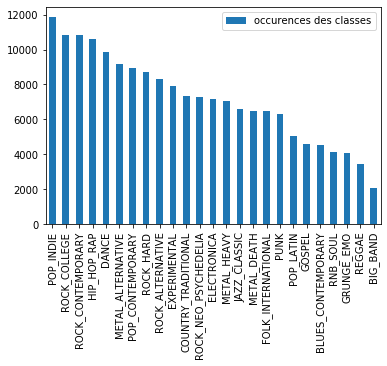

In [5]:
features_list = pd.read_csv(dataset_path_tab[0], header=None, sep = ',')
Y = features_list.iloc[:,-1]
df = pd.DataFrame(Y.value_counts())
ax = df.plot(kind='bar')
ax.legend(["occurences des classes"]);

Cette analyse nous montre que la plupart des classes apparaissent environ 7000 fois. Le dataset n'est toutefois pas balancé puisque le nombre d'occurences des classes peut varier entre 2000 et 12000. C'est une caractéristique du dataset qu'il faudra prendre en compte par la suite.

[168, 26, 16, 96, 20, 10, 124, 420, 60, 420]


Text(0.5, 1.0, 'Number of features per dataset')

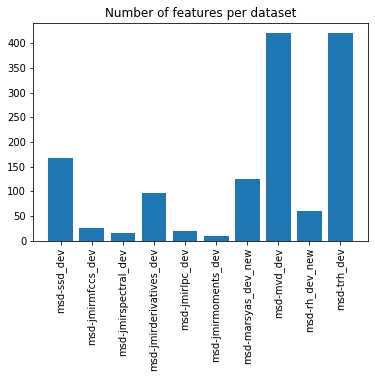

In [6]:
nb_features = []
dataset_path_label = []
for dataset_path in dataset_path_tab:
    features_list = pd.read_csv(dataset_path, header=None, sep = ',', nrows=1)
    nb_features.append(len(features_list.iloc[0,2:-1]))
    dataset_path_label.append(dataset_path.split('/')[2])
    
print(nb_features)
plt.bar(dataset_path_label,nb_features )
plt.xticks(dataset_path_label, rotation='vertical')
plt.title("Number of features per dataset")

Ainsi, on peut remarquer que le nombre de features varie beaucoup en fonction du dataset utilisé. Le nombre de features est particulièrement élevé avec les datasets MVD et TRH. Ces informations sont très utiles pour déterminer s'il est nécessaire de réduire ce nombre avec un algorithme d'analyse en composantes principales (PCA) par exemple.

## Question 2

Comme expliqué précedemment, le modèle MLP est un bon candidat. Toutefois, nous n'avons pas de données sur sa performance avec les ensembles de features du dataset MSD. Nous allons donc créé un modèle MLP est le tester sur tout les ensembles de features disponible pour comparer ses performances. Nous irons plus en détails dans l'ajustement des hyperparamètres par la suite.  
### Validation
Nous utiliserons ici une méthode validation hold-out avec 80% du dataset comme données d'entrainement et 20% en tant que données de tests. Nous utilisons cette méthode de validation pour le choix du partitionnement puisqu'elle à l'avantage d'être plus rapide que la validation croisée.
### Prétraitement
Par ailleurs, on utilise l'option "stratify" de la fonction train_test_split pour que les proportions de chacune des classes soit égale dans le dataset d'entrainement et de celui de test.
On normalise aussi indépendemment chaque features par rapport à la valeur maximale dans le dataset.

#### CLASS_WEIGHTS????

### Configuration de l'environnement
Ici le programme à été exécuté sur une machine ayant les caractéristiques suivantes :

### Partitionnement des données
Pour déterminer au mieux le partitionnement des données, nous testons les performances de chaque modèle choisi avec chaque ensemble de features. Nous irons plus en détails dans l'ajustement des hyperparamètres des modèles par la suite.

In [7]:
from RN_model import RN_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import shutil
import time
import numpy as np
from functions import get_data, plot_perf_epochs,plot_perf_delay

Instructions for updating:
non-resource variables are not supported in the long term


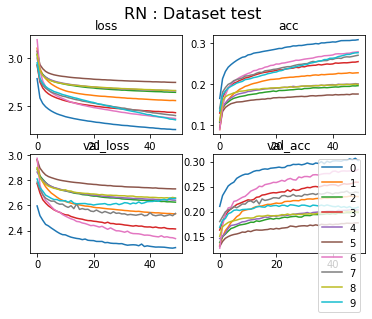

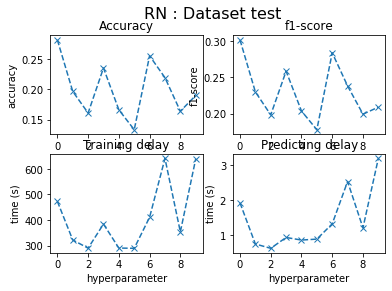

In [19]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)  

# Pour affichage
sub_title = ['loss','acc','val_loss','val_acc']
x_lab = "epochs"
leg = [str(i) for i in range(len(dataset_path_tab))]  
titre = "RN : Dataset test"                                                                                                                                         

plot_perf_epochs(ho, leg, titre ,sub_title)
plot_perf_delay(f1_RN,acc_RN,training_delay_RN,predicting_delay_RN,titre)

In [20]:
dataset_path_tab = []
dataset_path_tab.append("./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv")

In [21]:
# MLP hyperparamaters
layer_sizes = [500]
epochs = 50
learning_rate = 0.0005
batch_size = 500

dropout = 0.5

In [22]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0
f1_RN = []
acc_RN = []

In [23]:
try:      
    shutil.rmtree('./logs')
except:
    print("nothing to delete")
# Callbacks pour affichage des performances dans tensorboard : callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(len(dataset_path_tab)):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006

nothing to delete


In [17]:
cpt = 0
for path_ in dataset_path_tab:
    # Get data / normalize it / split into train&test
    X, Y,le = get_data(path_)
    X = preprocessing.normalize(X, norm='max',axis = 0)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,random_state=60, stratify=Y)  # 80% training and 20% test

    # Calcul du nombres de features/classes et taille du dataset
    nb_features = len(X[0])
    nb_classes = max(Y)+1
    train_size = len(X)

    model = RN_model(layer_sizes, dropout, learning_rate, nb_features, nb_classes)
    
    #### Apprentissage                                                                                                                                                               
    start = time.time()                                                                                                                   
    hist_obj = model.fit(X_train[0:train_size], Y_train[0:train_size], batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]]) 
    end = time.time()
    training_delay_RN.append(end - start)
    
    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                  
    start = time.time()
    Y_pred_temp = model.predict(X_test)
    end = time.time()
    predicting_delay_RN.append(end - start)

    # Remise en forme de Y_pred
    Y_pred = []
    for i in Y_pred_temp:
        Y_pred.append(np.argmax(i)) 
    
    f1 = metrics.f1_score(Y_test, Y_pred,average='weighted')
    acc = metrics.accuracy_score(Y_test, Y_pred)
    print("acc :", acc,"f1 :", f1)
    
    f1_RN.append(f1)
    acc_RN.append(acc)
    cpt+=1

Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 9s 60us/sample - loss: 2.7865 - acc: 0.1644 - val_loss: 2.5965 - val_acc: 0.2105
Epoch 2/50
143644/143644 [==============================] - 8s 59us/sample - loss: 2.5822 - acc: 0.2126 - val_loss: 2.5193 - val_acc: 0.2321
Epoch 3/50
143644/143644 [==============================] - 9s 65us/sample - loss: 2.5241 - acc: 0.2301 - val_loss: 2.4826 - val_acc: 0.2416
Epoch 4/50
143644/143644 [==============================] - 8s 59us/sample - loss: 2.4899 - acc: 0.2406 - val_loss: 2.4499 - val_acc: 0.2513
Epoch 5/50
143644/143644 [==============================] - 8s 58us/sample - loss: 2.4654 - acc: 0.2470 - val_loss: 2.4377 - val_acc: 0.2557
Epoch 6/50
143644/143644 [==============================] - 9s 65us/sample - loss: 2.4451 - acc: 0.2524 - val_loss: 2.4212 - val_acc: 0.2589
Epoch 7/50
143644/143644 [==============================] - 10s 68us/sample - loss: 2.4290 - acc: 0.257

143644/143644 [==============================] - 6s 40us/sample - loss: 2.7117 - acc: 0.1808 - val_loss: 2.6831 - val_acc: 0.1899
Epoch 8/50
143644/143644 [==============================] - 7s 46us/sample - loss: 2.6947 - acc: 0.1864 - val_loss: 2.6662 - val_acc: 0.1936
Epoch 9/50
143644/143644 [==============================] - 7s 50us/sample - loss: 2.6808 - acc: 0.1897 - val_loss: 2.6515 - val_acc: 0.2012
Epoch 10/50
143644/143644 [==============================] - 8s 54us/sample - loss: 2.6695 - acc: 0.1938 - val_loss: 2.6416 - val_acc: 0.2029
Epoch 11/50
143644/143644 [==============================] - 6s 43us/sample - loss: 2.6585 - acc: 0.1959 - val_loss: 2.6317 - val_acc: 0.2043
Epoch 12/50
143644/143644 [==============================] - 7s 46us/sample - loss: 2.6501 - acc: 0.1987 - val_loss: 2.6250 - val_acc: 0.2048
Epoch 13/50
143644/143644 [==============================] - 8s 54us/sample - loss: 2.6448 - acc: 0.2009 - val_loss: 2.6188 - val_acc: 0.2081
Epoch 14/50
143644/1

143644/143644 [==============================] - 7s 47us/sample - loss: 2.7124 - acc: 0.1757 - val_loss: 2.6989 - val_acc: 0.1816
Epoch 15/50
143644/143644 [==============================] - 6s 42us/sample - loss: 2.7071 - acc: 0.1777 - val_loss: 2.6956 - val_acc: 0.1804
Epoch 16/50
143644/143644 [==============================] - 6s 40us/sample - loss: 2.7035 - acc: 0.1783 - val_loss: 2.6930 - val_acc: 0.1819
Epoch 17/50
143644/143644 [==============================] - 6s 42us/sample - loss: 2.6996 - acc: 0.1795 - val_loss: 2.6867 - val_acc: 0.1836
Epoch 18/50
143644/143644 [==============================] - 6s 42us/sample - loss: 2.6960 - acc: 0.1804 - val_loss: 2.6843 - val_acc: 0.1850
Epoch 19/50
143644/143644 [==============================] - 5s 37us/sample - loss: 2.6926 - acc: 0.1811 - val_loss: 2.6829 - val_acc: 0.1862
Epoch 20/50
143644/143644 [==============================] - 5s 38us/sample - loss: 2.6903 - acc: 0.1825 - val_loss: 2.6776 - val_acc: 0.1850
Epoch 21/50
143644

/home/ens/AN03460/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.19821224694383335 f1 : 0.16116896120952337
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 8s 54us/sample - loss: 2.9290 - acc: 0.1285 - val_loss: 2.7746 - val_acc: 0.1632
Epoch 2/50
143644/143644 [==============================] - 8s 52us/sample - loss: 2.7512 - acc: 0.1661 - val_loss: 2.6998 - val_acc: 0.1807
Epoch 3/50
143644/143644 [==============================] - 7s 49us/sample - loss: 2.6878 - acc: 0.1810 - val_loss: 2.6460 - val_acc: 0.1925
Epoch 4/50
143644/143644 [==============================] - 8s 53us/sample - loss: 2.6515 - acc: 0.1904 - val_loss: 2.6193 - val_acc: 0.2007
Epoch 5/50
143644/143644 [==============================] - 8s 53us/sample - loss: 2.6262 - acc: 0.1969 - val_loss: 2.5973 - val_acc: 0.2055
Epoch 6/50
143644/143644 [==============================] - 8s 55us/sample - loss: 2.6081 - acc: 0.2018 - val_loss: 2.5818 - val_acc: 0.2093
Epoch 7/50
143644/143644 [==========================

143644/143644 [==============================] - 6s 40us/sample - loss: 2.7617 - acc: 0.1737 - val_loss: 2.7425 - val_acc: 0.1747
Epoch 8/50
143644/143644 [==============================] - 6s 40us/sample - loss: 2.7524 - acc: 0.1758 - val_loss: 2.7367 - val_acc: 0.1770
Epoch 9/50
143644/143644 [==============================] - 6s 40us/sample - loss: 2.7461 - acc: 0.1773 - val_loss: 2.7302 - val_acc: 0.1796
Epoch 10/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.7394 - acc: 0.1786 - val_loss: 2.7235 - val_acc: 0.1801
Epoch 11/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.7339 - acc: 0.1813 - val_loss: 2.7172 - val_acc: 0.1824
Epoch 12/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.7293 - acc: 0.1818 - val_loss: 2.7130 - val_acc: 0.1835
Epoch 13/50
143644/143644 [==============================] - 6s 42us/sample - loss: 2.7241 - acc: 0.1835 - val_loss: 2.7082 - val_acc: 0.1843
Epoch 14/50
143644/1

/home/ens/AN03460/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.20353095151903317 f1 : 0.1664258559366996
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 6s 45us/sample - loss: 3.0768 - acc: 0.0927 - val_loss: 2.9640 - val_acc: 0.1304
Epoch 2/50
143644/143644 [==============================] - 6s 39us/sample - loss: 2.9344 - acc: 0.1323 - val_loss: 2.8977 - val_acc: 0.1405
Epoch 3/50
143644/143644 [==============================] - 5s 36us/sample - loss: 2.8917 - acc: 0.1422 - val_loss: 2.8669 - val_acc: 0.1469
Epoch 4/50
143644/143644 [==============================] - 6s 42us/sample - loss: 2.8636 - acc: 0.1474 - val_loss: 2.8433 - val_acc: 0.1502
Epoch 5/50
143644/143644 [==============================] - 6s 42us/sample - loss: 2.8467 - acc: 0.1515 - val_loss: 2.8300 - val_acc: 0.1527
Epoch 6/50
143644/143644 [==============================] - 7s 47us/sample - loss: 2.8358 - acc: 0.1534 - val_loss: 2.8216 - val_acc: 0.1544
Epoch 7/50
143644/143644 [===========================

/home/ens/AN03460/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.17766144078416085 f1 : 0.1337880984946185
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 9s 60us/sample - loss: 3.1987 - acc: 0.0883 - val_loss: 2.9751 - val_acc: 0.1271
Epoch 2/50
143644/143644 [==============================] - 9s 61us/sample - loss: 2.8733 - acc: 0.1439 - val_loss: 2.7639 - val_acc: 0.1719
Epoch 3/50
143644/143644 [==============================] - 9s 62us/sample - loss: 2.7620 - acc: 0.1723 - val_loss: 2.6844 - val_acc: 0.1959
Epoch 4/50
143644/143644 [==============================] - 8s 57us/sample - loss: 2.7019 - acc: 0.1891 - val_loss: 2.6404 - val_acc: 0.2074
Epoch 5/50
143644/143644 [==============================] - 8s 57us/sample - loss: 2.6645 - acc: 0.1993 - val_loss: 2.6199 - val_acc: 0.2089
Epoch 6/50
143644/143644 [==============================] - 9s 61us/sample - loss: 2.6409 - acc: 0.2053 - val_loss: 2.5919 - val_acc: 0.2205
Epoch 7/50
143644/143644 [===========================

143644/143644 [==============================] - 12s 87us/sample - loss: 2.6331 - acc: 0.2102 - val_loss: 2.6350 - val_acc: 0.2077
Epoch 8/50
143644/143644 [==============================] - 12s 87us/sample - loss: 2.6232 - acc: 0.2123 - val_loss: 2.6192 - val_acc: 0.2111
Epoch 9/50
143644/143644 [==============================] - 13s 92us/sample - loss: 2.6111 - acc: 0.2142 - val_loss: 2.6101 - val_acc: 0.2153
Epoch 10/50
143644/143644 [==============================] - 13s 92us/sample - loss: 2.6016 - acc: 0.2189 - val_loss: 2.6110 - val_acc: 0.2150
Epoch 11/50
143644/143644 [==============================] - 12s 86us/sample - loss: 2.5960 - acc: 0.2194 - val_loss: 2.5948 - val_acc: 0.2202
Epoch 12/50
143644/143644 [==============================] - 13s 88us/sample - loss: 2.5858 - acc: 0.2213 - val_loss: 2.5848 - val_acc: 0.2215
Epoch 13/50
143644/143644 [==============================] - 13s 92us/sample - loss: 2.5789 - acc: 0.2225 - val_loss: 2.5981 - val_acc: 0.2180
Epoch 14/50
1

Epoch 14/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.7173 - acc: 0.1869 - val_loss: 2.7056 - val_acc: 0.1905
Epoch 15/50
143644/143644 [==============================] - 6s 44us/sample - loss: 2.7148 - acc: 0.1866 - val_loss: 2.7025 - val_acc: 0.1913
Epoch 16/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.7122 - acc: 0.1883 - val_loss: 2.7006 - val_acc: 0.1908
Epoch 17/50
143644/143644 [==============================] - 7s 48us/sample - loss: 2.7089 - acc: 0.1888 - val_loss: 2.6981 - val_acc: 0.1914
Epoch 18/50
143644/143644 [==============================] - 7s 47us/sample - loss: 2.7066 - acc: 0.1887 - val_loss: 2.6958 - val_acc: 0.1926
Epoch 19/50
143644/143644 [==============================] - 7s 48us/sample - loss: 2.7038 - acc: 0.1899 - val_loss: 2.6954 - val_acc: 0.1917
Epoch 20/50
143644/143644 [==============================] - 7s 48us/sample - loss: 2.7009 - acc: 0.1900 - val_loss: 2.6919 - val_acc: 0.1916
Epoch 

/home/ens/AN03460/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.1991868786722731 f1 : 0.16408495941899554
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 14s 96us/sample - loss: 2.9541 - acc: 0.1335 - val_loss: 2.8109 - val_acc: 0.1689
Epoch 2/50
143644/143644 [==============================] - 12s 87us/sample - loss: 2.7909 - acc: 0.1725 - val_loss: 2.7415 - val_acc: 0.1825
Epoch 3/50
143644/143644 [==============================] - 13s 89us/sample - loss: 2.7363 - acc: 0.1822 - val_loss: 2.7142 - val_acc: 0.1863
Epoch 4/50
143644/143644 [==============================] - 13s 91us/sample - loss: 2.7038 - acc: 0.1895 - val_loss: 2.6826 - val_acc: 0.1958
Epoch 5/50
143644/143644 [==============================] - 13s 91us/sample - loss: 2.6813 - acc: 0.1940 - val_loss: 2.6700 - val_acc: 0.1982
Epoch 6/50
143644/143644 [==============================] - 12s 87us/sample - loss: 2.6665 - acc: 0.1975 - val_loss: 2.6567 - val_acc: 0.2026
Epoch 7/50
143644/143644 [=====================

On remarque que le réseau de neurones performe mieux pour les dataset 0, 3 et 6, c'est à dire avec les ensemble de features : SSD, derivates et maryas.

Pour faire un choix éclairé, on réalise des tests similaires pour les 2 autres modèles choisis.

## Question 3
### Description des modèles et justifications


#### Etudes des hyperparamètres? complète avec tous les tests????????????????????????

## Question 4

### Matrice des expérimentations

### QU'est ce que c'est????????????????????????????????????
Matrices des performances?? accuracy/F1-scores pk "matrice"


### matrices de confusion!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
=> pas lisible du tout!!!!!!!!

### Matrice des résultats de l'étude des hyperparamètres
### QU'est ce que c'est????????????????????????????????????

### Graphiques

Comme pour le TP précédent, on peut étudier le modèle MLP selon les hyperparamètres suivant : 
  . Nombre de couches cachées
  . Nombre de perceptrons sur la couche cachée
  . Taux d'apprentissage
  . Nombre d'epochs

In [ ]:
from RN_hyperparam import *

In [2]:
layer_size_test()

nothing to delete
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 2s 14us/sample - loss: 2.7918 - acc: 0.1609 - val_loss: 2.5988 - val_acc: 0.2093
Epoch 2/50
143644/143644 [==============================] - 1s 10us/sample - loss: 2.5843 - acc: 0.2108 - val_loss: 2.5228 - val_acc: 0.2320
Epoch 3/50
143644/143644 [==============================] - 1s 10us/sample - loss: 2.5247 - acc: 0.2288 - val_loss: 2.4808 - val_acc: 0.2455
Epoch 4/50
143644/143644 [==============================] - 1s 10us/sample - loss: 2.4885 - acc: 0.2391 - val_loss: 2.4534 - val_acc: 0.2504
Epoch 5/50
143644/143644 [==============================] - 1s 10us/sample - loss: 2.4626 - acc: 0.2475 - val_loss: 2.4307 - val_acc: 0.2562
Epoch 6/50
143644/143644 [=============

Epoch 3/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.5379 - acc: 0.2247 - val_loss: 2.4644 - val_acc: 0.2447
Epoch 4/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.5002 - acc: 0.2352 - val_loss: 2.4350 - val_acc: 0.2566
Epoch 5/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4728 - acc: 0.2436 - val_loss: 2.4058 - val_acc: 0.2626
Epoch 6/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4519 - acc: 0.2497 - val_loss: 2.3909 - val_acc: 0.2682
Epoch 7/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4347 - acc: 0.2557 - val_loss: 2.3739 - val_acc: 0.2739
Epoch 8/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4236 - acc: 0.2585 - val_loss: 2.3686 - val_acc: 0.2744
Epoch 9/50
143644/143644 [==============================] - 2s 17us/sample - loss: 2.4119 - acc: 0.2628 - val_loss: 2.3705 - val_acc: 0.2725
Epoch 10/50
1

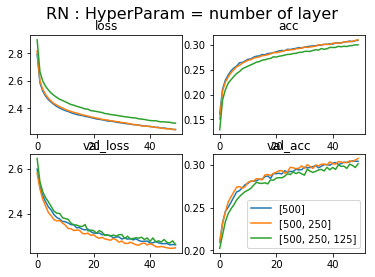

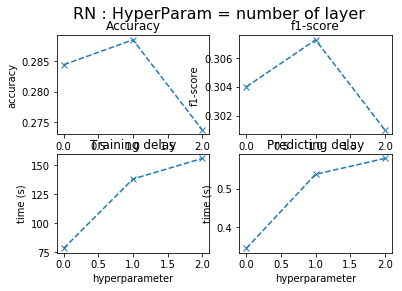

In [3]:
RN_plot_test()

In [25]:
from RN_hyperparam import *
perceptrons_number_test()

[3.50778999 1.59206428 0.98167777 0.72657562 1.00485484 0.90541443
 1.11093581 1.56816594 1.75335978 0.67876669 1.09359726 0.78109842
 1.10750964 1.02146844 0.80169667 0.60570947 1.42292224 1.13890188
 2.09241078 1.74855752 0.8619502  0.66157283 0.66325291 0.82364679
 0.98843282]
nothing to delete
Train on 143644 samples, validate on 35911 samples
Epoch 1/100
143644/143644 [==============================] - 5s 32us/sample - loss: 2.8315 - acc: 0.1488 - val_loss: 2.6100 - val_acc: 0.2093
Epoch 2/100
143644/143644 [==============================] - 5s 32us/sample - loss: 2.6285 - acc: 0.1981 - val_loss: 2.5423 - val_acc: 0.2256
Epoch 3/100
143644/143644 [==============================] - 4s 28us/sample - loss: 2.5692 - acc: 0.2179 - val_loss: 2.4894 - val_acc: 0.2386
Epoch 4/100
143644/143644 [==============================] - 4s 28us/sample - loss: 2.5368 - acc: 0.2277 - val_loss: 2.4736 - val_acc: 0.2451
Epoch 5/100
143644/143644 [==============================] - 4s 26us/sample - loss

Epoch 56/100
143644/143644 [==============================] - 5s 37us/sample - loss: 2.3240 - acc: 0.2891 - val_loss: 2.2853 - val_acc: 0.2970
Epoch 57/100
143644/143644 [==============================] - 5s 32us/sample - loss: 2.3215 - acc: 0.2874 - val_loss: 2.2914 - val_acc: 0.2932
Epoch 58/100
143644/143644 [==============================] - 4s 27us/sample - loss: 2.3174 - acc: 0.2907 - val_loss: 2.2858 - val_acc: 0.2956
Epoch 59/100
143644/143644 [==============================] - 5s 32us/sample - loss: 2.3192 - acc: 0.2895 - val_loss: 2.2864 - val_acc: 0.2961
Epoch 60/100
143644/143644 [==============================] - 5s 34us/sample - loss: 2.3150 - acc: 0.2908 - val_loss: 2.2980 - val_acc: 0.2921
Epoch 61/100
143644/143644 [==============================] - 4s 31us/sample - loss: 2.3183 - acc: 0.2897 - val_loss: 2.2906 - val_acc: 0.2947
Epoch 62/100
143644/143644 [==============================] - 5s 34us/sample - loss: 2.3154 - acc: 0.2914 - val_loss: 2.2947 - val_acc: 0.2943

143644/143644 [==============================] - 9s 64us/sample - loss: 2.3417 - acc: 0.2790 - val_loss: 2.3223 - val_acc: 0.2858
Epoch 13/100
143644/143644 [==============================] - 9s 63us/sample - loss: 2.3371 - acc: 0.2828 - val_loss: 2.3222 - val_acc: 0.2866
Epoch 14/100
143644/143644 [==============================] - 8s 59us/sample - loss: 2.3297 - acc: 0.2847 - val_loss: 2.3174 - val_acc: 0.2888
Epoch 15/100
143644/143644 [==============================] - 9s 60us/sample - loss: 2.3251 - acc: 0.2855 - val_loss: 2.3193 - val_acc: 0.2880
Epoch 16/100
143644/143644 [==============================] - 9s 66us/sample - loss: 2.3189 - acc: 0.2875 - val_loss: 2.3052 - val_acc: 0.2922
Epoch 17/100
143644/143644 [==============================] - 9s 63us/sample - loss: 2.3128 - acc: 0.2899 - val_loss: 2.3071 - val_acc: 0.2915
Epoch 18/100
143644/143644 [==============================] - 9s 63us/sample - loss: 2.3066 - acc: 0.2918 - val_loss: 2.3251 - val_acc: 0.2853
Epoch 19/100

143644/143644 [==============================] - 9s 62us/sample - loss: 2.1536 - acc: 0.3316 - val_loss: 2.2306 - val_acc: 0.3132
Epoch 70/100
143644/143644 [==============================] - 10s 71us/sample - loss: 2.1530 - acc: 0.3329 - val_loss: 2.2292 - val_acc: 0.3155
Epoch 71/100
143644/143644 [==============================] - 9s 60us/sample - loss: 2.1506 - acc: 0.3308 - val_loss: 2.2347 - val_acc: 0.3141
Epoch 72/100
143644/143644 [==============================] - 9s 63us/sample - loss: 2.1506 - acc: 0.3317 - val_loss: 2.2209 - val_acc: 0.3161
Epoch 73/100
143644/143644 [==============================] - 9s 60us/sample - loss: 2.1463 - acc: 0.3339 - val_loss: 2.2288 - val_acc: 0.3142
Epoch 74/100
143644/143644 [==============================] - 9s 60us/sample - loss: 2.1446 - acc: 0.3338 - val_loss: 2.2251 - val_acc: 0.3162
Epoch 75/100
143644/143644 [==============================] - 8s 58us/sample - loss: 2.1440 - acc: 0.3346 - val_loss: 2.2306 - val_acc: 0.3138
Epoch 76/10

KeyboardInterrupt: 

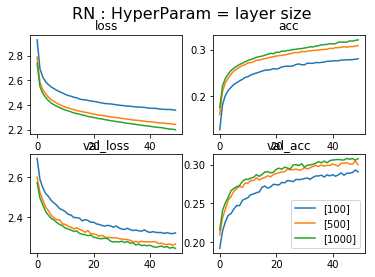

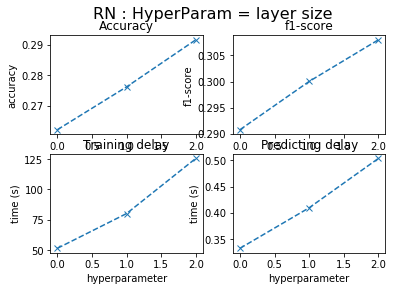

In [5]:
RN_plot_test()

In [6]:
learning_rate_test()

nothing to delete
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 2s 12us/sample - loss: 3.1988 - acc: 0.0633 - val_loss: 3.1686 - val_acc: 0.1024
Epoch 2/50
143644/143644 [==============================] - 2s 10us/sample - loss: 3.1499 - acc: 0.0822 - val_loss: 3.1229 - val_acc: 0.1062
Epoch 3/50
143644/143644 [==============================] - 2s 11us/sample - loss: 3.1091 - acc: 0.0956 - val_loss: 3.0811 - val_acc: 0.1223
Epoch 4/50
143644/143644 [==============================] - 2s 11us/sample - loss: 3.0694 - acc: 0.1092 - val_loss: 3.0372 - val_acc: 0.1341
Epoch 5/50
143644/143644 [==============================] - 2s 11us/sample - loss: 3.0250 - acc: 0.1198 - val_loss: 2.9908 - val_acc: 0.1362
Epoch 6/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.9816 - acc: 0.1279 - val_loss: 2.9458 - val_acc: 0.1439
Epoch 7/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.

/home/ens/AQ38840/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.2178998078583164 f1 : 0.17180858411074612
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 2s 12us/sample - loss: 2.7953 - acc: 0.1605 - val_loss: 2.6072 - val_acc: 0.2075
Epoch 2/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.5916 - acc: 0.2081 - val_loss: 2.5254 - val_acc: 0.2294
Epoch 3/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.5316 - acc: 0.2270 - val_loss: 2.4843 - val_acc: 0.2402
Epoch 4/50
143644/143644 [==============================] - 2s 12us/sample - loss: 2.4930 - acc: 0.2379 - val_loss: 2.4524 - val_acc: 0.2520
Epoch 5/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4688 - acc: 0.2450 - val_loss: 2.4310 - val_acc: 0.2596
Epoch 6/50
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4476 - acc: 0.2522 - val_loss: 2.4134 - val_acc: 0.2639
Epoch 7/50
143644/143644 [===========================

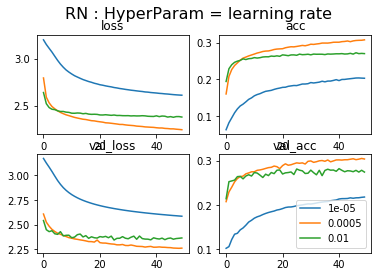

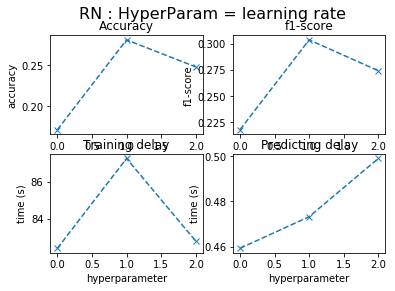

In [7]:
RN_plot_test()

In [8]:
epochs_number_test()

nothing to delete
Train on 143644 samples, validate on 35911 samples
Epoch 1/10
143644/143644 [==============================] - 2s 12us/sample - loss: 2.7921 - acc: 0.1609 - val_loss: 2.6109 - val_acc: 0.2040
Epoch 2/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.5900 - acc: 0.2105 - val_loss: 2.5302 - val_acc: 0.2325
Epoch 3/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.5302 - acc: 0.2274 - val_loss: 2.4811 - val_acc: 0.2440
Epoch 4/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4926 - acc: 0.2392 - val_loss: 2.4518 - val_acc: 0.2511
Epoch 5/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4676 - acc: 0.2471 - val_loss: 2.4283 - val_acc: 0.2583
Epoch 6/10
143644/143644 [==============================] - 2s 11us/sample - loss: 2.4481 - acc: 0.2528 - val_loss: 2.4216 - val_acc: 0.2615
Epoch 7/10
143644/143644 [==============================] - 2s 12us/sample - loss: 2.

143644/143644 [==============================] - 3s 18us/sample - loss: 2.2363 - acc: 0.3105 - val_loss: 2.2518 - val_acc: 0.3059
Epoch 54/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2355 - acc: 0.3107 - val_loss: 2.2534 - val_acc: 0.3066
Epoch 55/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2327 - acc: 0.3125 - val_loss: 2.2513 - val_acc: 0.3078
Epoch 56/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2323 - acc: 0.3112 - val_loss: 2.2561 - val_acc: 0.3073
Epoch 57/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2289 - acc: 0.3146 - val_loss: 2.2546 - val_acc: 0.3070
Epoch 58/2000
143644/143644 [==============================] - 3s 19us/sample - loss: 2.2276 - acc: 0.3140 - val_loss: 2.2452 - val_acc: 0.3095
Epoch 59/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.2278 - acc: 0.3128 - val_loss: 2.2458 - val_acc: 0.3095
Epoch 

Epoch 110/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1461 - acc: 0.3345 - val_loss: 2.2218 - val_acc: 0.3172
Epoch 111/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1486 - acc: 0.3351 - val_loss: 2.2225 - val_acc: 0.3166
Epoch 112/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1455 - acc: 0.3351 - val_loss: 2.2213 - val_acc: 0.3181
Epoch 113/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1449 - acc: 0.3355 - val_loss: 2.2241 - val_acc: 0.3162
Epoch 114/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1431 - acc: 0.3351 - val_loss: 2.2164 - val_acc: 0.3193
Epoch 115/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1430 - acc: 0.3362 - val_loss: 2.2221 - val_acc: 0.3174
Epoch 116/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 2.1428 - acc: 0.3347 - val_loss: 2.2207 - v

143644/143644 [==============================] - 2s 12us/sample - loss: 2.0419 - acc: 0.3617 - val_loss: 2.2089 - val_acc: 0.3255
Epoch 223/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 2.0434 - acc: 0.3619 - val_loss: 2.2083 - val_acc: 0.3242
Epoch 224/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0393 - acc: 0.3637 - val_loss: 2.2098 - val_acc: 0.3248
Epoch 225/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0396 - acc: 0.3626 - val_loss: 2.2138 - val_acc: 0.3239
Epoch 226/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0370 - acc: 0.3636 - val_loss: 2.2109 - val_acc: 0.3231
Epoch 227/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0380 - acc: 0.3626 - val_loss: 2.2065 - val_acc: 0.3244
Epoch 228/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 2.0364 - acc: 0.3637 - val_loss: 2.2137 - val_acc: 0.3235


143644/143644 [==============================] - 2s 11us/sample - loss: 1.9754 - acc: 0.3784 - val_loss: 2.2229 - val_acc: 0.3233
Epoch 335/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9740 - acc: 0.3799 - val_loss: 2.2210 - val_acc: 0.3260
Epoch 336/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9750 - acc: 0.3792 - val_loss: 2.2242 - val_acc: 0.3260
Epoch 337/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9745 - acc: 0.3794 - val_loss: 2.2341 - val_acc: 0.3252
Epoch 338/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9746 - acc: 0.3792 - val_loss: 2.2288 - val_acc: 0.3236
Epoch 339/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9766 - acc: 0.3790 - val_loss: 2.2209 - val_acc: 0.3257
Epoch 340/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9729 - acc: 0.3805 - val_loss: 2.2268 - val_acc: 0.3252


143644/143644 [==============================] - 2s 11us/sample - loss: 1.9322 - acc: 0.3903 - val_loss: 2.2495 - val_acc: 0.3233
Epoch 447/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9285 - acc: 0.3906 - val_loss: 2.2516 - val_acc: 0.3256
Epoch 448/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9283 - acc: 0.3905 - val_loss: 2.2461 - val_acc: 0.3230
Epoch 449/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9316 - acc: 0.3895 - val_loss: 2.2448 - val_acc: 0.3240
Epoch 450/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9330 - acc: 0.3889 - val_loss: 2.2481 - val_acc: 0.3256
Epoch 451/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9305 - acc: 0.3898 - val_loss: 2.2528 - val_acc: 0.3242
Epoch 452/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.9308 - acc: 0.3895 - val_loss: 2.2430 - val_acc: 0.3237


143644/143644 [==============================] - 2s 11us/sample - loss: 1.8990 - acc: 0.3942 - val_loss: 2.2788 - val_acc: 0.3238
Epoch 559/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8977 - acc: 0.3975 - val_loss: 2.2732 - val_acc: 0.3243
Epoch 560/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8991 - acc: 0.3974 - val_loss: 2.2780 - val_acc: 0.3244
Epoch 561/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8991 - acc: 0.3962 - val_loss: 2.2787 - val_acc: 0.3227
Epoch 562/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8954 - acc: 0.3974 - val_loss: 2.2791 - val_acc: 0.3217
Epoch 563/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8987 - acc: 0.3963 - val_loss: 2.2694 - val_acc: 0.3217
Epoch 564/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8973 - acc: 0.3962 - val_loss: 2.2798 - val_acc: 0.3227


143644/143644 [==============================] - 2s 11us/sample - loss: 1.8749 - acc: 0.4011 - val_loss: 2.2987 - val_acc: 0.3207
Epoch 671/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8720 - acc: 0.4040 - val_loss: 2.2998 - val_acc: 0.3193
Epoch 672/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8709 - acc: 0.4033 - val_loss: 2.3041 - val_acc: 0.3228
Epoch 673/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8696 - acc: 0.4027 - val_loss: 2.2971 - val_acc: 0.3213
Epoch 674/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8725 - acc: 0.4017 - val_loss: 2.2987 - val_acc: 0.3213
Epoch 675/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8713 - acc: 0.4018 - val_loss: 2.2950 - val_acc: 0.3217
Epoch 676/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.8721 - acc: 0.4032 - val_loss: 2.2953 - val_acc: 0.3237


143644/143644 [==============================] - 3s 18us/sample - loss: 1.8532 - acc: 0.4061 - val_loss: 2.3392 - val_acc: 0.3185
Epoch 783/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8526 - acc: 0.4060 - val_loss: 2.3247 - val_acc: 0.3195
Epoch 784/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8486 - acc: 0.4068 - val_loss: 2.3267 - val_acc: 0.3197
Epoch 785/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8509 - acc: 0.4066 - val_loss: 2.3348 - val_acc: 0.3186
Epoch 786/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8513 - acc: 0.4064 - val_loss: 2.3206 - val_acc: 0.3199
Epoch 787/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8501 - acc: 0.4072 - val_loss: 2.3359 - val_acc: 0.3197
Epoch 788/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8525 - acc: 0.4064 - val_loss: 2.3356 - val_acc: 0.3192


143644/143644 [==============================] - 3s 18us/sample - loss: 1.8327 - acc: 0.4098 - val_loss: 2.3591 - val_acc: 0.3179
Epoch 895/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8356 - acc: 0.4103 - val_loss: 2.3570 - val_acc: 0.3185
Epoch 896/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8363 - acc: 0.4087 - val_loss: 2.3547 - val_acc: 0.3160
Epoch 897/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8323 - acc: 0.4108 - val_loss: 2.3573 - val_acc: 0.3197
Epoch 898/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8359 - acc: 0.4087 - val_loss: 2.3507 - val_acc: 0.3166
Epoch 899/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8355 - acc: 0.4099 - val_loss: 2.3580 - val_acc: 0.3177
Epoch 900/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8337 - acc: 0.4099 - val_loss: 2.3531 - val_acc: 0.3175


143644/143644 [==============================] - 3s 18us/sample - loss: 1.8203 - acc: 0.4131 - val_loss: 2.3633 - val_acc: 0.3163
Epoch 1007/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8188 - acc: 0.4141 - val_loss: 2.3788 - val_acc: 0.3179
Epoch 1008/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8208 - acc: 0.4129 - val_loss: 2.3687 - val_acc: 0.3158
Epoch 1009/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8207 - acc: 0.4123 - val_loss: 2.3793 - val_acc: 0.3155
Epoch 1010/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8185 - acc: 0.4145 - val_loss: 2.3683 - val_acc: 0.3161
Epoch 1011/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8200 - acc: 0.4111 - val_loss: 2.3835 - val_acc: 0.3165
Epoch 1012/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8179 - acc: 0.4131 - val_loss: 2.3816 - val_acc: 0

143644/143644 [==============================] - 3s 17us/sample - loss: 1.8082 - acc: 0.4143 - val_loss: 2.3963 - val_acc: 0.3155
Epoch 1119/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8043 - acc: 0.4171 - val_loss: 2.4150 - val_acc: 0.3151
Epoch 1120/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8076 - acc: 0.4143 - val_loss: 2.4074 - val_acc: 0.3139
Epoch 1121/2000
143644/143644 [==============================] - 3s 19us/sample - loss: 1.8095 - acc: 0.4137 - val_loss: 2.3937 - val_acc: 0.3152
Epoch 1122/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8063 - acc: 0.4157 - val_loss: 2.4042 - val_acc: 0.3168
Epoch 1123/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8090 - acc: 0.4159 - val_loss: 2.4191 - val_acc: 0.3156
Epoch 1124/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.8067 - acc: 0.4141 - val_loss: 2.4030 - val_acc: 0

Epoch 1230/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7951 - acc: 0.4168 - val_loss: 2.4224 - val_acc: 0.3138
Epoch 1231/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7964 - acc: 0.4174 - val_loss: 2.4273 - val_acc: 0.3132
Epoch 1232/2000
143644/143644 [==============================] - 2s 15us/sample - loss: 1.7964 - acc: 0.4163 - val_loss: 2.4339 - val_acc: 0.3144
Epoch 1233/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7968 - acc: 0.4167 - val_loss: 2.4351 - val_acc: 0.3111
Epoch 1234/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7955 - acc: 0.4158 - val_loss: 2.4491 - val_acc: 0.3136
Epoch 1235/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7940 - acc: 0.4182 - val_loss: 2.4410 - val_acc: 0.3145
Epoch 1236/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7958 - acc: 0.4167 - val_loss: 2.4

143644/143644 [==============================] - 2s 11us/sample - loss: 1.7846 - acc: 0.4188 - val_loss: 2.4588 - val_acc: 0.3129
Epoch 1343/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7854 - acc: 0.4192 - val_loss: 2.4591 - val_acc: 0.3162
Epoch 1344/2000
143644/143644 [==============================] - 2s 14us/sample - loss: 1.7874 - acc: 0.4175 - val_loss: 2.4663 - val_acc: 0.3134
Epoch 1345/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7889 - acc: 0.4183 - val_loss: 2.4653 - val_acc: 0.3131
Epoch 1346/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7845 - acc: 0.4190 - val_loss: 2.4667 - val_acc: 0.3124
Epoch 1347/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7841 - acc: 0.4184 - val_loss: 2.4587 - val_acc: 0.3131
Epoch 1348/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7859 - acc: 0.4175 - val_loss: 2.4666 - val_acc: 0

143644/143644 [==============================] - 3s 19us/sample - loss: 1.7783 - acc: 0.4192 - val_loss: 2.4786 - val_acc: 0.3142
Epoch 1455/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7741 - acc: 0.4205 - val_loss: 2.4989 - val_acc: 0.3145
Epoch 1456/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7789 - acc: 0.4188 - val_loss: 2.4834 - val_acc: 0.3133
Epoch 1457/2000
143644/143644 [==============================] - 3s 19us/sample - loss: 1.7753 - acc: 0.4194 - val_loss: 2.4984 - val_acc: 0.3130
Epoch 1458/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7756 - acc: 0.4211 - val_loss: 2.4897 - val_acc: 0.3135
Epoch 1459/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7776 - acc: 0.4194 - val_loss: 2.4817 - val_acc: 0.3122
Epoch 1460/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7772 - acc: 0.4210 - val_loss: 2.4994 - val_acc: 0

143644/143644 [==============================] - 2s 12us/sample - loss: 1.7668 - acc: 0.4214 - val_loss: 2.5123 - val_acc: 0.3101
Epoch 1567/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7658 - acc: 0.4227 - val_loss: 2.5084 - val_acc: 0.3126
Epoch 1568/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7701 - acc: 0.4215 - val_loss: 2.5209 - val_acc: 0.3132
Epoch 1569/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7701 - acc: 0.4201 - val_loss: 2.5213 - val_acc: 0.3126
Epoch 1570/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7709 - acc: 0.4218 - val_loss: 2.5119 - val_acc: 0.3132
Epoch 1571/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7690 - acc: 0.4212 - val_loss: 2.5034 - val_acc: 0.3107
Epoch 1572/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7681 - acc: 0.4216 - val_loss: 2.5223 - val_acc: 0

143644/143644 [==============================] - 2s 12us/sample - loss: 1.7601 - acc: 0.4219 - val_loss: 2.5468 - val_acc: 0.3115
Epoch 1679/2000
143644/143644 [==============================] - 2s 12us/sample - loss: 1.7606 - acc: 0.4236 - val_loss: 2.5306 - val_acc: 0.3124
Epoch 1680/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7578 - acc: 0.4240 - val_loss: 2.5442 - val_acc: 0.3117
Epoch 1681/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7629 - acc: 0.4216 - val_loss: 2.5488 - val_acc: 0.3121
Epoch 1682/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7597 - acc: 0.4234 - val_loss: 2.5405 - val_acc: 0.3122
Epoch 1683/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7618 - acc: 0.4223 - val_loss: 2.5430 - val_acc: 0.3106
Epoch 1684/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7597 - acc: 0.4230 - val_loss: 2.5408 - val_acc: 0

143644/143644 [==============================] - 3s 18us/sample - loss: 1.7521 - acc: 0.4237 - val_loss: 2.5706 - val_acc: 0.3115
Epoch 1791/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7511 - acc: 0.4247 - val_loss: 2.5746 - val_acc: 0.3106
Epoch 1792/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7557 - acc: 0.4244 - val_loss: 2.5845 - val_acc: 0.3104
Epoch 1793/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7566 - acc: 0.4222 - val_loss: 2.5731 - val_acc: 0.3110
Epoch 1794/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7556 - acc: 0.4223 - val_loss: 2.5656 - val_acc: 0.3111
Epoch 1795/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7551 - acc: 0.4217 - val_loss: 2.5731 - val_acc: 0.3107
Epoch 1796/2000
143644/143644 [==============================] - 3s 18us/sample - loss: 1.7510 - acc: 0.4242 - val_loss: 2.5792 - val_acc: 0

143644/143644 [==============================] - 2s 11us/sample - loss: 1.7459 - acc: 0.4248 - val_loss: 2.6009 - val_acc: 0.3109
Epoch 1903/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7469 - acc: 0.4262 - val_loss: 2.6055 - val_acc: 0.3115
Epoch 1904/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7470 - acc: 0.4251 - val_loss: 2.6101 - val_acc: 0.3108
Epoch 1905/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7463 - acc: 0.4260 - val_loss: 2.6013 - val_acc: 0.3118
Epoch 1906/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7463 - acc: 0.4267 - val_loss: 2.6093 - val_acc: 0.3095
Epoch 1907/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7490 - acc: 0.4259 - val_loss: 2.6172 - val_acc: 0.3105
Epoch 1908/2000
143644/143644 [==============================] - 2s 11us/sample - loss: 1.7477 - acc: 0.4247 - val_loss: 2.5986 - val_acc: 0

TypeError: 'int' object is not subscriptable

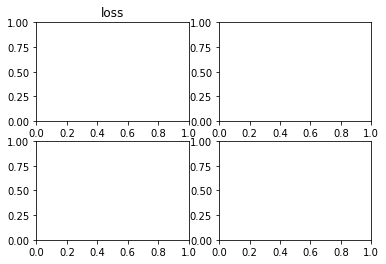

In [26]:
RN_plot_test()

### Discussion

## Question 5
### Présentation de la conception


A FAIRE : SAUVEGARDE DES MODELES DANS DES PICKLE
faire diagramme

In [5]:
# Persistence avec Sklearn
# A tester
import pickle
# Save the model
pickle_out = open("SVM.pickle", "wb")
pickle.dump(clf,pickle_out)

# Load the model
pickle_in = open("SVM.pickle", "rb")
clf2 = pickle.loads(pickle_in)

NameError: name 'model' is not defined

In [ ]:
# Persistence avec tensorflow
# Save NN weights with callback
# Load weigths :
checkpoint_path = "MLP_model/cp.ckpt"
model2 = RN_model(layer_sizes, dropout, learning_rate, nb_features, nb_classes)
model2.load_weights(checkpoint_path)

## Question 6
### Hyperparamètres des modèles choisis dans la conception


### Matrice des résultats

### Discussion

comparaison entre les modèles prit independemment et les modèles combinés

## Question 7 
### Formulation des recommandations

## Conclusion